In [1]:
from demand_forecasting.walmart_data import WalmartDataloader, WalmartFeatures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

--- Fase 1 y 2: Cargando y Procesando Datos ---

--- Fase 3: Dividiendo Datos ---
Datos de Entrenamiento: 5265 filas
Datos de Validación:   1170 filas

--- Fase 3: Entrenando Modelo ---
Iniciando entrenamiento...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 5265, number of used features: 9
[LightGBM] [Info] Start training from score 955913.687500
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 168708
[200]	valid_0's l1: 78957.4
[300]	valid_0's l1: 51124.6
[400]	valid_0's l1: 41571
[500]	valid_0's l1: 39421.4
[600]	valid_0's l1: 38817.4
[700]	valid_0's l1: 38544.6
[800]	valid_0's l1: 38295.8
[900]	valid_0's l1: 38178.6
[1000]	valid_0's l1: 38140.9
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 38138.7
¡Entrenamiento completado!

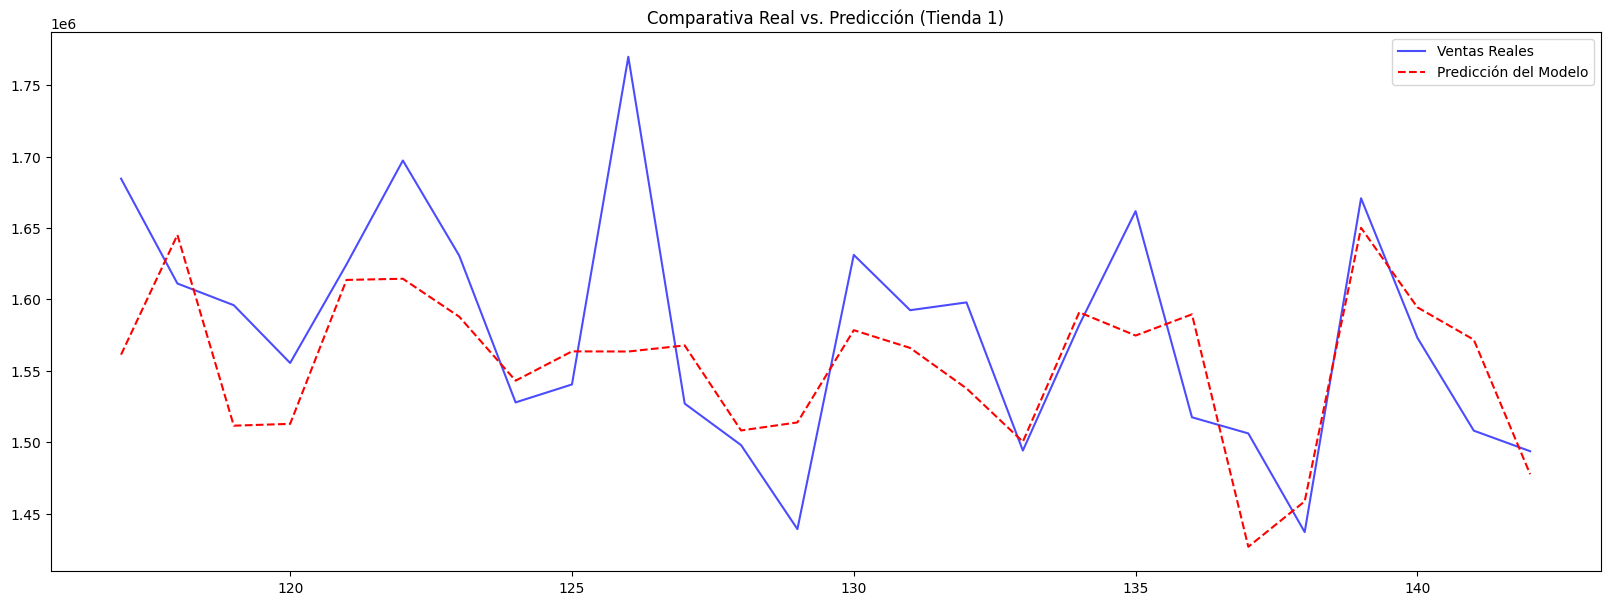

Guardando gráfico de importancia en: outputs/plots/importancia_caracteristicas.png


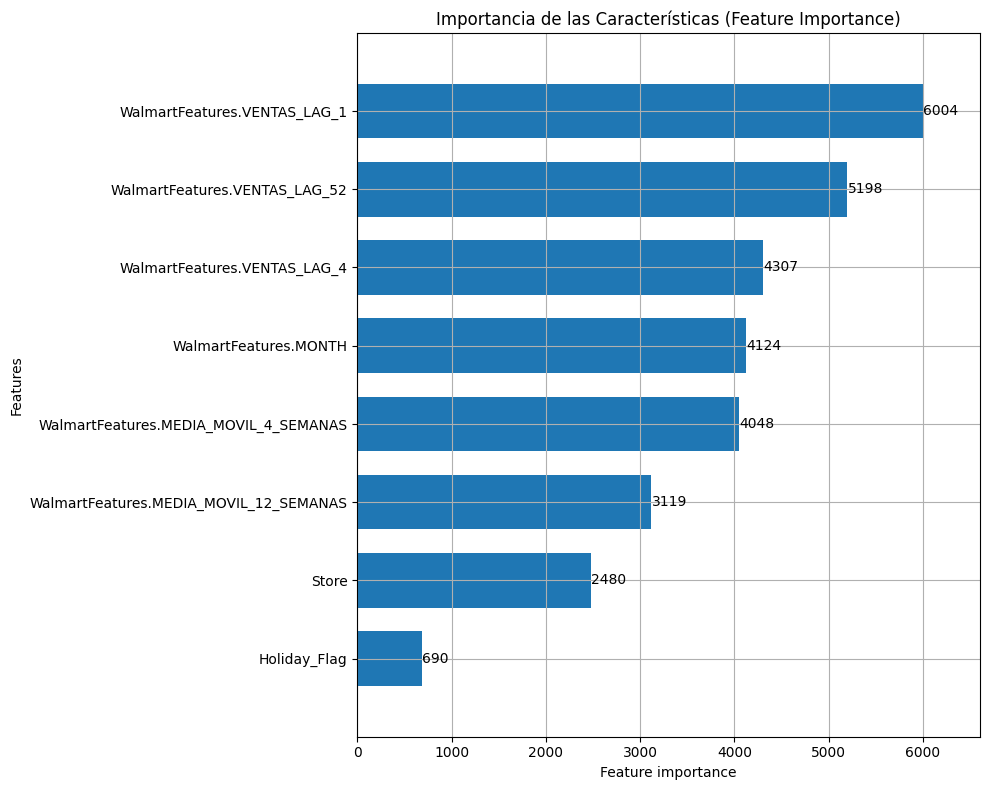


¡Pipeline de entrenamiento completado!


In [1]:
# run_training.py
from pathlib import Path
from demand_forecasting.walmart_data import WalmartDataloader, WalmartFeatures
from demand_forecasting.model import train_model, evaluate_model, save_model
from demand_forecasting.plotting import plot_predictions, plot_feature_importance
from demand_forecasting.trainers.lightGBM import LightGBMTrainer
from demand_forecasting.trainers import split_data_by_date

# --- 0. Configuración del Proyecto ---
OUTPUT_PATH = Path("outputs")
MODELS_PATH = OUTPUT_PATH / "models"
PLOTS_PATH = OUTPUT_PATH / "plots"

# Crear directorios de salida
MODELS_PATH.mkdir(parents=True, exist_ok=True)
PLOTS_PATH.mkdir(parents=True, exist_ok=True)

# Constantes del modelo
FECHA_CORTE_VAL = '2012-05-01'
OBJETIVO = WalmartFeatures.WEEKLY_SALES.value
CARACTERISTICAS = [
    WalmartFeatures.STORE.value,
    WalmartFeatures.HOLIDAY_FLAG.value,
    WalmartFeatures.MONTH.value,
    WalmartFeatures.QUARTER.value,
    WalmartFeatures.VENTAS_LAG_1.value,
    WalmartFeatures.VENTAS_LAG_4.value,
    WalmartFeatures.VENTAS_LAG_52.value,
    WalmartFeatures.MEDIA_MOVIL_4_SEMANAS.value,
    WalmartFeatures.MEDIA_MOVIL_12_SEMANAS.value,
 ]
CARACTERISTICAS_CATEGORICAS = [
    WalmartFeatures.STORE.value,
    WalmartFeatures.HOLIDAY_FLAG.value,
    WalmartFeatures.MONTH.value,
    WalmartFeatures.QUARTER.value
]

def main():
    """Ejecuta el pipeline completo de entrenamiento."""
    
    # --- 1. Cargar y Procesar Datos ---
    print("--- Fase 1 y 2: Cargando y Procesando Datos ---")
    data_loader = WalmartDataloader()
    df = data_loader.get_clean_data()
    trainer = LightGBMTrainer()
    # --- 2. Dividir Datos ---
    print("\n--- Fase 3: Dividiendo Datos ---")
    X_train, y_train, X_val, y_val = split_data_by_date(
        df, FECHA_CORTE_VAL, CARACTERISTICAS, OBJETIVO
    )
    
    # --- 3. Entrenar Modelo ---
    print("\n--- Fase 3: Entrenando Modelo ---")
    trainer.train(X_train, y_train, X_val, y_val, CARACTERISTICAS_CATEGORICAS)
    
    # --- 4. Evaluar Modelo ---
    print("\n--- Fase 4: Evaluando Modelo ---")
    trainer.evaluate(X_val, y_val)

    # --- 5. Guardar Artefactos (Modelo y Gráficos) ---
    print("\n--- Fase 4: Guardando Artefactos ---")
    trainer.save(MODELS_PATH / "lgbm_walmart_model.joblib")

    
    # Obtener predicciones para los gráficos
    predicciones = trainer.predict(X_val)
    val_data_original = df[df[WalmartFeatures.DATE.value] >= FECHA_CORTE_VAL] # Necesitamos el df original
    
    plot_predictions(
        val_data_original, 
        predicciones, 
        store_id=1, 
        save_path=PLOTS_PATH / "predicciones_tienda_1.png"
    )
    
    plot_feature_importance(
        trainer.model, 
        save_path=PLOTS_PATH / "importancia_caracteristicas.png"
    )
    
    print("\n¡Pipeline de entrenamiento completado!")

if __name__ == "__main__":
    main()